# Read and plot DTS data
This notebook shows how to read DTS data from a .csv file and plot it.

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from sklearn.metrics import r2_score
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary
from pysindy.optimizers import STLSQ
from pysindy.feature_library import CustomLibrary

# import cv2

# matplotlib.use('TkAgg')
%matplotlib inline

# Set up data

In [2]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [3]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [4]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = datetime.datetime(2023,8,9)
end_time = datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [16]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 
filtered_arr = scipy.ndimage.gaussian_filter(plot_arr, 10, axes=1)

startt = datetime.datetime(2023, 8, 25, 16) # 25
endt = datetime.datetime(2023, 8, 25, 18) # 25
startind_t = np.absolute(plot_times - startt).argmin()
endind_t = np.absolute(plot_times - endt).argmin()

# startind_d = np.absolute(plot_dists - 2940).argmin()
# endind_d = np.absolute(plot_dists - 3000).argmin()

startind_d = np.absolute(plot_dists - 2900).argmin()
endind_d = np.absolute(plot_dists - 3300).argmin()

filtered_arr = scipy.ndimage.gaussian_filter(filtered_arr[startind_t:endind_t, startind_d:endind_d], 1.2)
plot_times_zoomed = plot_times[startind_t:endind_t]
plot_times_zoomed_int = plot_times_zoomed.astype('int64')
plot_dists_zoomed = plot_dists[startind_d:endind_d]

# Detecting the amplitude of the waves

## Making my own contours

In [17]:
contour_values = np.linspace(0.55, 2.2, 100) # 0.55
contour_values_legend = []
for i in range(len(contour_values)): contour_values_legend.append(str(contour_values[i]) + "ºC")

contour_points = {}
contour_points_arr = np.empty((len(contour_values), len(plot_times_zoomed)))
# np.empty((len(contour_values), len(filtered_arr[:, 1])))
nan_inds = {}
real_inds = {}
depths_arr = np.empty((len(contour_values), len(plot_times_zoomed)))
cvi = 0

for cv in contour_values:
    avg_zero_crossings = 0
    nan_inds[cvi] = []
    real_inds[cvi] = []
    contour_points[cv] = {}
    contour_points[cv]['x'] = []
    contour_points[cv]['t'] = []
    for i in range(len(filtered_arr[:, 0])):
        xc = pyaC.zerocross1d(plot_dists_zoomed, filtered_arr[i, :] - cv)
        if(len(xc) == 1):
            real_inds[cvi].append(i)
            contour_points_arr[cvi, i] = xc.flatten().tolist()[0]
            contour_points[cv]['x'].extend(xc.flatten().tolist())
            contour_points[cv]['t'].extend(np.full(len(xc), plot_times_zoomed_int[i]).tolist())
        else:
            nan_inds[cvi].append(i)
            contour_points_arr[cvi, i] = float('NaN')
        avg_zero_crossings = avg_zero_crossings + len(xc)
    # print('Temp contour =', cv, 'avg of', avg_zero_crossings/len(filtered_arr[:, 0]), 'zero crossings')
    
    nan_inds[cvi] = np.array(nan_inds[cvi])
    real_inds[cvi] = np.array(real_inds[cvi])

    cvi = cvi + 1

contour_points_arr_interp = np.empty( (100, len(plot_times_zoomed)) )
depths = np.nanmedian(contour_points_arr, axis=1)
depths_interp = np.linspace(plot_dists_zoomed[0], plot_dists_zoomed[-1], len(contour_points_arr_interp[:, 0]))

for i in range(len(contour_points_arr[0, :])):
    real_inds = np.where(~np.isnan(contour_points_arr[:, i]))[0]
    contour_points_arr_interp[:, i] = np.interp(depths_interp, depths[real_inds], contour_points_arr[real_inds, i])

# np.interp(xc, plot_dists_zoomed, filtered_arr[i, :])

## Plotting

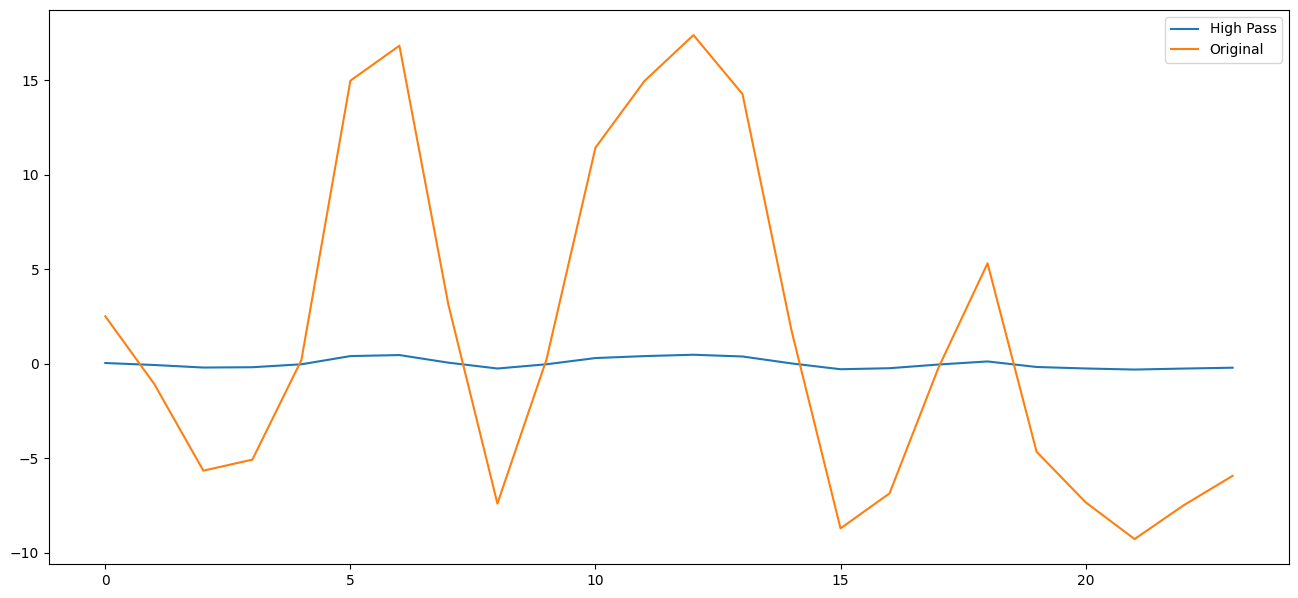

In [49]:
depths = np.empty(np.shape(contour_points_arr_interp))
displacements = np.empty(np.shape(contour_points_arr_interp))

filter = scipy.signal.butter(1, 0.5, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate. Used to be 0.5 cutoff

for i in range(len(contour_points_arr_interp[:, 0])):
    depths[i, :] = depths_interp[i]
    # High pass filter each channel
    # contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))
    displacements[i, :] = contour_points_arr_interp[i, :] - np.mean(contour_points_arr_interp[i, :])
    # displacements[i, :] = contours_high_pass #contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :])   #  contours_high_pass

# displacements = contour_points_arr_interp - np.median(contour_points_arr_interp)
## Normalize displacements ## 
displacements = (displacements - np.min(displacements)) / (np.max(displacements) - np.min(displacements))
displacements = 2 * displacements - 1

i = 60 # np.absolute(depths - 3027).argmin()
contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax.plot(displacements[i, :])
ax.plot(contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))
# ax.plot(contour_points_arr[i, :] - np.median(contour_points_arr[i, :]))
ax.legend(['High Pass', 'Original'])

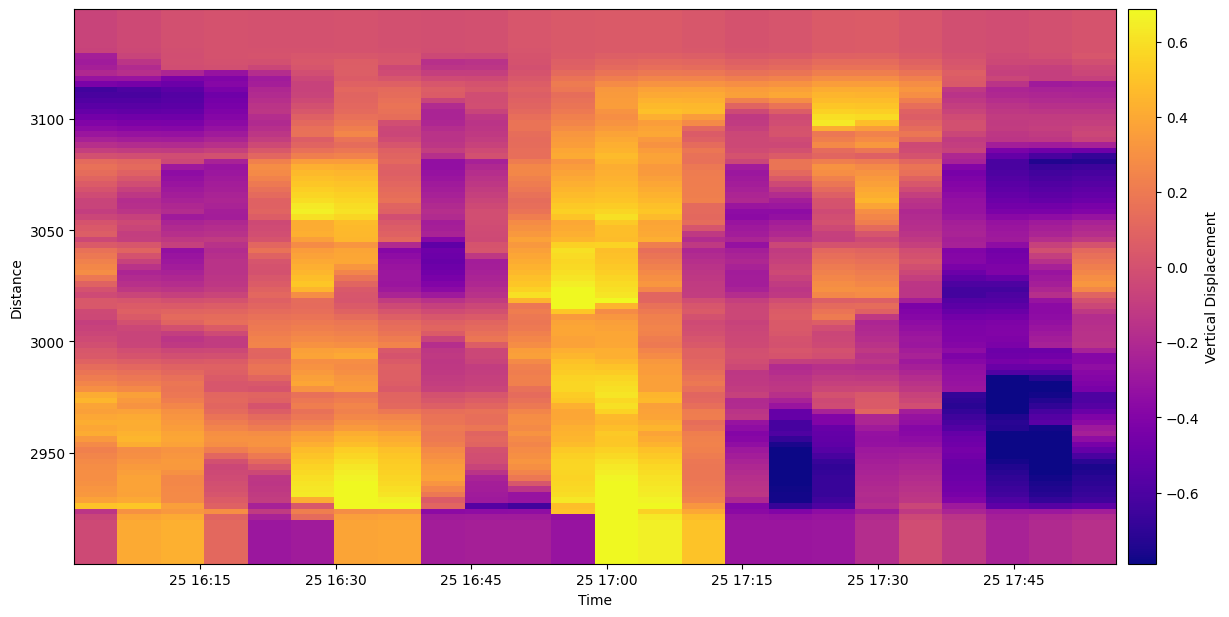

In [50]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(displacements[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + displacements[i, :])
ddt = np.gradient(displacements, axis=1)
im1 = ax.imshow(displacements, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(displacements[~np.isnan(displacements)],1),
            vmax=np.percentile(displacements[~np.isnan(displacements)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()


## Temperature plotted data and slice of disps

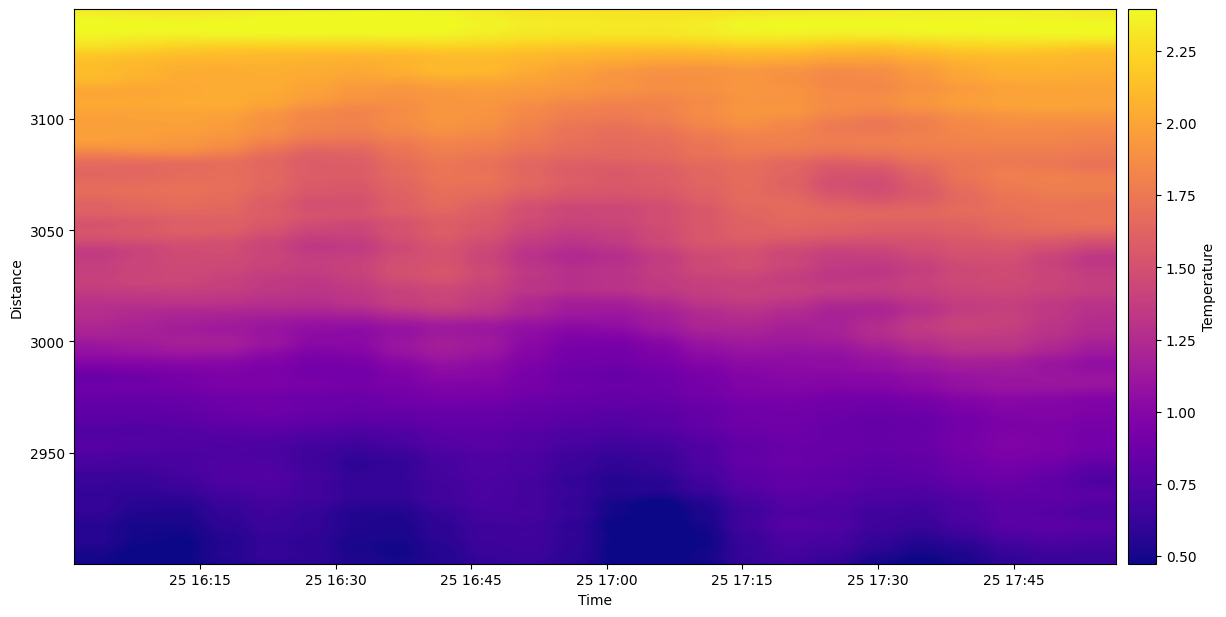

In [51]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr[~np.isnan(filtered_arr)],1),
            vmax=np.percentile(filtered_arr[~np.isnan(filtered_arr)],99),
            )
# for i in range(len(contour_values)): plt.plot(plot_times_zoomed, contour_points_arr[i], '-')
# for i in range(len(contour_values)): plt.plot(contour_points[contour_values[i]]['t'], contour_points[contour_values[i]]['x'], '.')
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)

ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature')
plt.show()

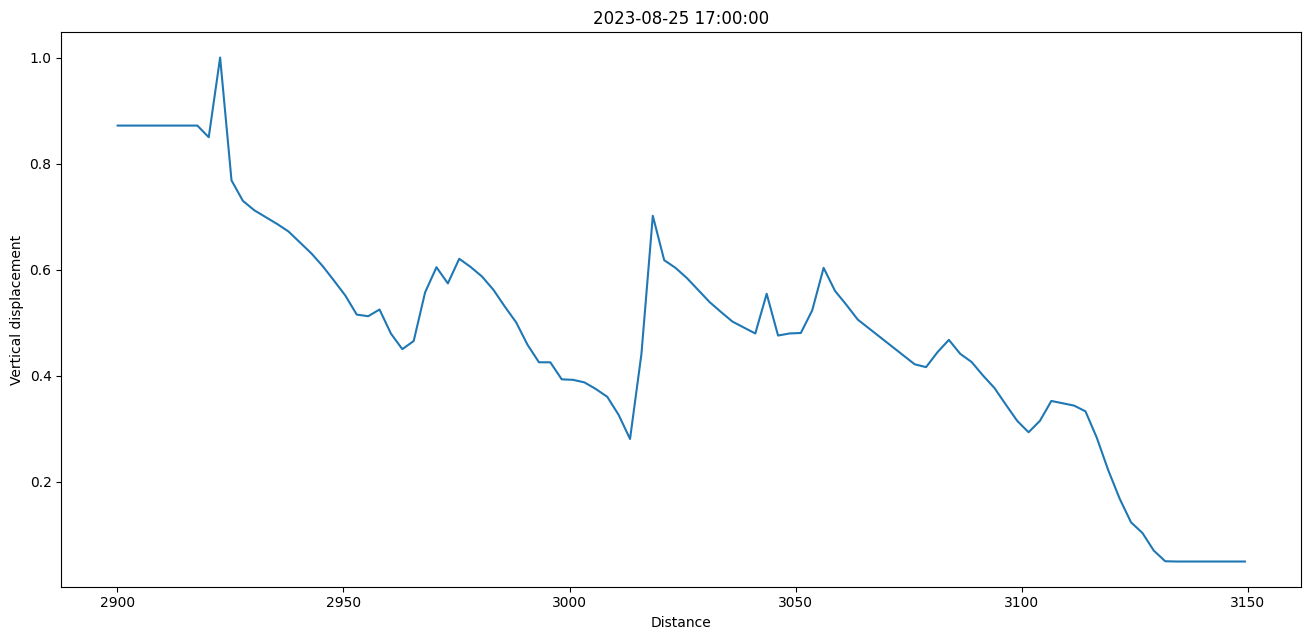

In [52]:
time_slice = datetime.datetime(2023, 8, 25, 17)
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax.plot(depths[:, np.absolute(plot_times_zoomed - time_slice).argmin()], displacements[:, np.absolute(plot_times_zoomed - time_slice).argmin()])
ax.set_xlabel('Distance')
ax.set_ylabel('Vertical displacement')
ax.set_title(str(time_slice))
plt.show()

# Set up SINDy

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

## Actual SINDy Stuff

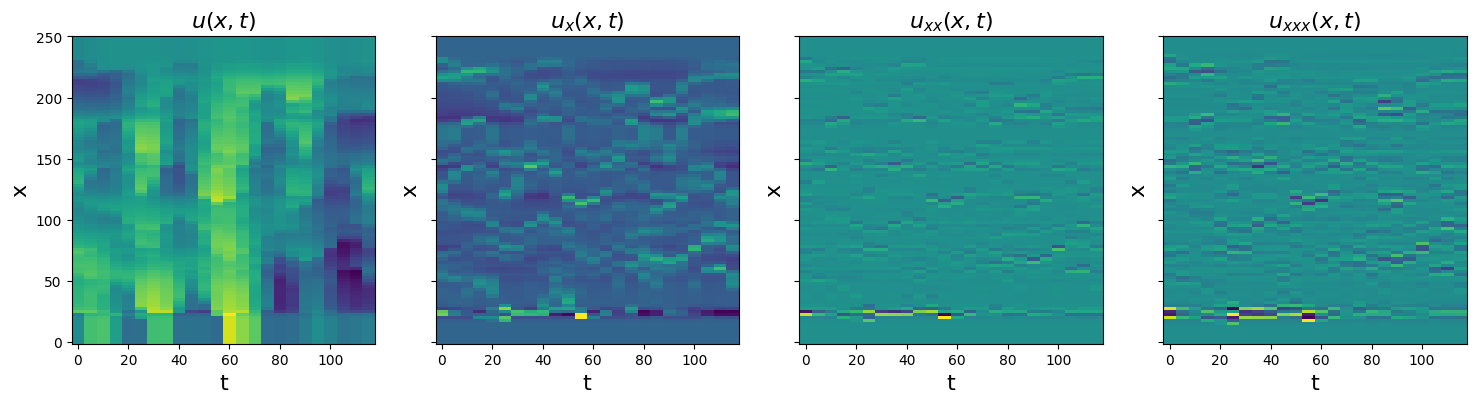

In [54]:
# Example data (replace with your actual data)
train_ind = -1
t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths[:, 0] - depths[0, 0] # grid_y[0, :]
dt = t[1] - t[0]
dx = x[1] - x[0]

u_sol = displacements


u = np.zeros((len(x), len(t), 1))
u[:, :, 0] = u_sol
u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

ux = ps.FiniteDifference(d=1, axis=0)._differentiate(u, dx)
uxx = ps.FiniteDifference(d=2, axis=0)._differentiate(u, dx)
uxxx = ps.FiniteDifference(d=3, axis=0)._differentiate(u, dx)

# Plot derivative results
plt.figure(figsize=(18, 4))
plt.subplot(1, 4, 1)
plt.pcolormesh(t, x, u[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.subplot(1, 4, 2)
plt.pcolormesh(t, x, ux[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{x}(x, t)$', fontsize=16)
plt.subplot(1, 4, 3)
plt.pcolormesh(t, x, uxx[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xx}(x, t)$', fontsize=16)
plt.subplot(1, 4, 4)
plt.pcolormesh(t, x, uxxx[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xxx}(x, t)$', fontsize=16)
plt.show()


In [59]:
# Define PDE library that is quadratic in u, and 
# third-order in spatial derivatives of u.
spatiotemporal_grid=np.zeros((len(x),len(t),2))
spatiotemporal_grid[:,:,0]=x[:,np.newaxis]
spatiotemporal_grid[:,:,1]=t[np.newaxis,:]

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
np.random.seed(1)

In [61]:
multiindices=np.array([[0,1],[1,0],[2,0],[3,0]])
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=2, spatial_grid=x, temporal_grid=t,
                        include_bias=False, is_uniform=True,implicit_terms=True, multiindices=multiindices)

sindy_opt = ps.SINDyPI(
    threshold=1e-1, max_iter=1000, tol=1e-10,
    thresholder='l1', normalize_columns=False
)
model = ps.SINDy(feature_library=pde_lib, optimizer=sindy_opt)
model.fit(u, t=dt)
model.print()
# print('score', model.score(u,t=dt))

Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
Model  10
Model  11
Model  12
Model  13
x0 = -0.088 x0x0 + -0.637 x0_t + -0.767 x0_1 + -0.669 x0_11 + -1.478 x0_111 + 0.014 x0x0_t + 5.586 x0x0x0_t + -4.433 x0x0_1 + -2.948 x0x0x0_1 + 0.369 x0x0_11 + -23.754 x0x0x0_11
x0x0 = -0.028 x0 + -0.273 x0_t + -0.285 x0_1 + 0.997 x0x0_t + 2.337 x0x0x0_t + -1.428 x0x0_1 + -2.945 x0x0x0_1 + -10.002 x0x0_11
x0_t = -0.006 x0 + -0.009 x0x0 + 2.630 x0x0x0_t
x0_1 = -0.002 x0 + -1.364 x0_111 + 1.395 x0x0x0_1
x0_11 = -0.005 x0 + -0.008 x0x0_1 + 0.482 x0x0x0_11
x0_111 = -0.068 x0_1
x0x0_t = 0.001 x0 + 0.007 x0x0 + 0.013 x0_t
x0x0x0_t = 0.002 x0 + 0.004 x0x0 + 0.115 x0_t
x0x0_1 = -0.029 x0_11
x0x0x0_1 = 0.083 x0_1
x0x0_11 = -0.007 x0x0 + -0.011 x0_1
x0x0x0_11 = -0.002 x0 + 0.034 x0_11
x0x0_111 = 0.000
x0x0x0_111 = 0.000


(100, 24, 14)


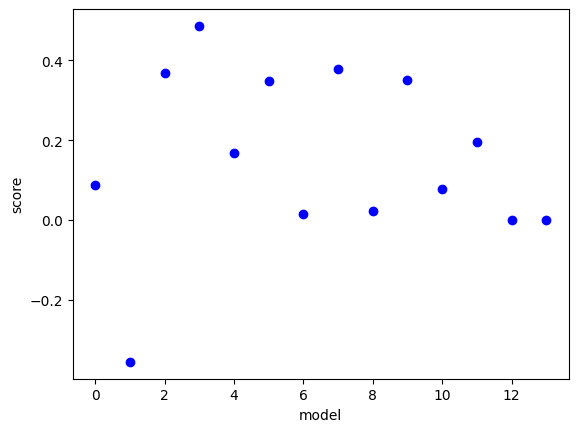

x0_1=-0.002 x0 + -1.364 x0_111 + 1.395 x0x0x0_1, score=0.48618622460756256
x0x0x0_t=0.002 x0 + 0.004 x0x0 + 0.115 x0_t, score=0.3794720749348076
x0_t=-0.006 x0 + -0.009 x0x0 + 2.630 x0x0x0_t, score=0.3680591555668242
x0x0x0_1=0.083 x0_1, score=0.3516884961669319
x0_111=-0.068 x0_1, score=0.3471813023620268


In [70]:
lhs_actual=pde_lib.transform(u)
lhs_predict=model.predict(u)


scores=[r2_score(np.reshape(lhs_actual[:,:,ind],(np.product(lhs_actual.shape[:-1]))),np.reshape(lhs_predict[:,:,ind],(np.product(lhs_actual.shape[:-1])))) for ind in range(lhs_predict.shape[-1])]

plt.plot(scores,'bo')
plt.xlabel('model')
plt.ylabel('score')
plt.show()

order=np.argsort(scores)
for ind in np.flip(order[-5:]):
    print(pde_lib.get_feature_names()[ind] + '=' + model.equations()[ind] + ', score=' +str(scores[ind]))

(100, 24)


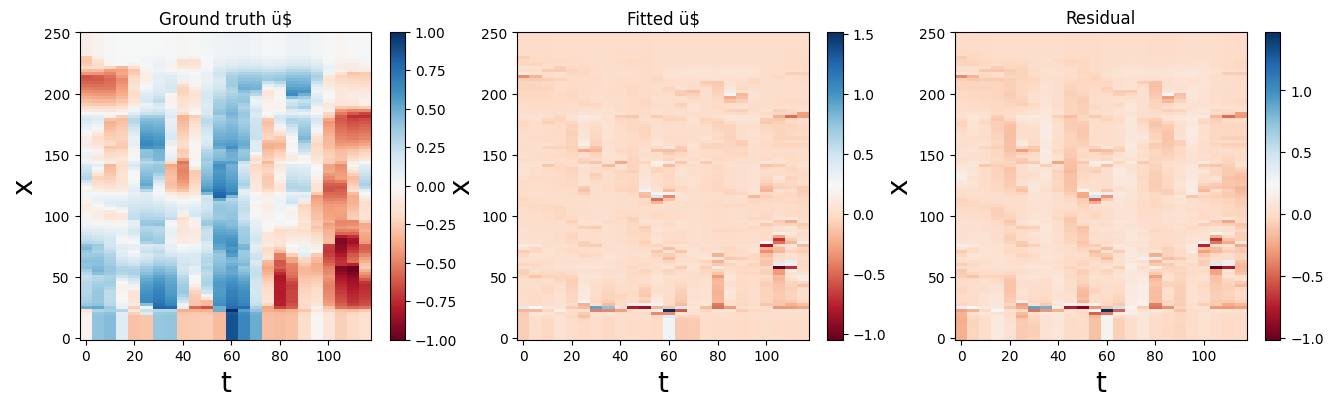

In [72]:
u_dot_pred = model.predict(u)
model_num = 3
# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
# plt.pcolormesh(t_test, x, u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot[:, :, 0], shading='nearest', cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Ground truth ü$')
ax = plt.gca()


plt.subplot(1, 3, 2)
# u_dot_stlsq = np.reshape(u_dot_stlsq, (len(x), len(t_test)))
# plt.pcolormesh(t_test, x, u_dot_stlsq, vmin=-1.5, vmax=1.5)
# u_dot_stlsq = np.reshape(u_dot_sr3, (len(x), len(t_test), 1))
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num], shading='nearest', cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Fitted ü$')
ax = plt.gca()

plt.subplot(1, 3, 3)
# plt.pcolormesh(t_test, x, u_dot_stlsq - u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num] - u_dot[:,:,0], cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

plt.show()

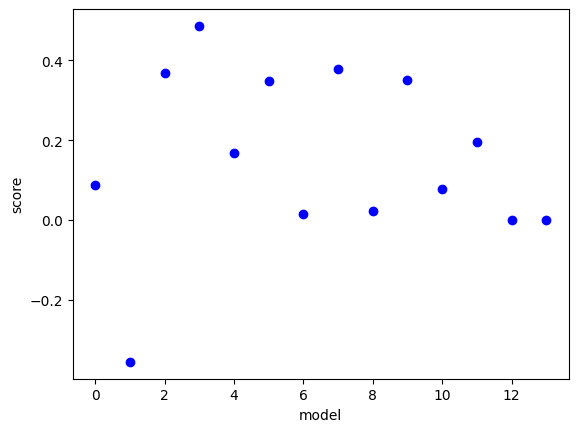

x0_1=-0.002 x0 + -1.364 x0_111 + 1.395 x0x0x0_1, score=0.48618622460756256
x0x0x0_t=0.002 x0 + 0.004 x0x0 + 0.115 x0_t, score=0.3794720749348076
x0_t=-0.006 x0 + -0.009 x0x0 + 2.630 x0x0x0_t, score=0.3680591555668242
x0x0x0_1=0.083 x0_1, score=0.3516884961669319
x0_111=-0.068 x0_1, score=0.3471813023620268


NameError: name 't_test' is not defined

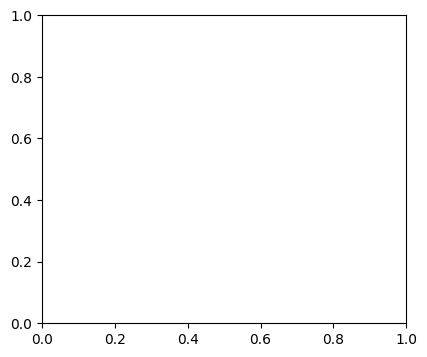

In [64]:
# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
# plt.pcolormesh(t_test, x, u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t_test, x, u_dot_test[:, :, 1], vmin=-1, vmax=1, shading='nearest', cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Ground truth ü')
ax = plt.gca()


plt.subplot(1, 3, 2)
# u_dot_stlsq = np.reshape(u_dot_stlsq, (len(x), len(t_test)))
# plt.pcolormesh(t_test, x, u_dot_stlsq, vmin=-1.5, vmax=1.5)
# u_dot_stlsq = np.reshape(u_dot_sr3, (len(x), len(t_test), 1))
plt.pcolormesh(t_test, x, u_dot_sr3[:,:,1], vmin=-1, vmax=1, shading='nearest', cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Fitted ü')
ax = plt.gca()

plt.subplot(1, 3, 3)
# plt.pcolormesh(t_test, x, u_dot_stlsq - u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t_test, x, u_dot_sr3[:,:,1] - u_dot_test[:,:,1], vmin=-1, vmax=1, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

plt.show()